In [372]:
import networkx as nx
import seaborn as sns
from pathlib import Path
import torch
import DQN_agent_modular
from envs.GraphEnv.impnode import ImpnodeEnv
from DQN.train_dqn import train_dqn, finetune_dqn, fill_memory
from test_and_compare import test_loop, hda
import matplotlib.pyplot as plt
import  numpy as np
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [373]:
import random

seed = 412
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.use_deterministic_algorithms(True,warn_only=True)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [374]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

RESULTS_BASEPATH_TEST1 = 'results\hyp_search_2\cuda_0.001_4000_1000_0.99_128_1500_300_1.0_0.05_300_0.001_4_2_32_64_1_3_(30, 50)_dw_nd_barabasi_albert_20240407152655'


In [375]:
# variables for training the agent

num_train_eps = 10 #10000 number training episodes to run
num_mem_fill_eps = 10 #1000 number of episodes to run to initialize the memory
discount = 0.99 # gamma used for computing return
batch_size = 64 # number of transitions to sample from replay buffer for each learn step
mem_capacity = 80 # 500000 size of the memory buffer
update_frequency = 5 #1000 number of interactions after which the target buffer is updated
eps_max = 0 # initial epsilon value
eps_min = 0 # final epsilon value
eps_step = 0 #1000 amount by which epsilon is decayed at each episode
lr = 0.0008 # learning rate for the network
alpha = 0.001
gnn_depth=4
state_size=2
hidden_size1=32
hidden_size2=64
action_size=1
n_step=3

num_nodes = (30, 50)
anc = 'dw_nd'

In [376]:
# create the dqn_agent
dqn_agent_train = DQN_agent_modular.DQNAgent(device,
                                             alpha=alpha,
                                             gnn_depth=gnn_depth,
                                             state_size=state_size,
                                             hidden_size1=hidden_size1,
                                             hidden_size2=hidden_size2,
                                             action_size=action_size,
                                             discount=discount,
                                             eps_max=eps_max,
                                             eps_min=eps_min,
                                             eps_step=eps_step,
                                             memory_capacity=mem_capacity,
                                             lr=lr,
                                             mode='finetune',
                                             unfrozen_layers = ['linear1', 'linear2', 'linear3', 'linear4', 'linear5', 'dense1', 'dense2']
                                             )
dqn_agent_train.load_model('{}/model.pt'.format(RESULTS_BASEPATH_TEST1))
#dqn_agent_train.save_model('{}_finetune/model.pt'.format(RESULTS_BASEPATH_TEST1))

linear1 is unfrozen
linear2 is unfrozen
linear3 is unfrozen
linear4 is unfrozen
sum_agg is frozen
linear5 is unfrozen
dense1 is unfrozen
dense2 is unfrozen


In [377]:
subdir = 'data/cm/WS_degree'
data_path = Path.cwd() / subdir
model_name = 'WS_finetuned_model'
env_train = ImpnodeEnv(anc=anc, 
                       g_type='barabasi_albert', 
                       num_nodes=num_nodes, 
                       mode='finetune',
                       data_path=data_path
                       )

val_data_path = 'data/cm/WS_degree_val'
val_data_path = Path.cwd()/val_data_path

In [378]:
fill_memory(env_train, dqn_agent_train, num_mem_fill_eps, n_step)

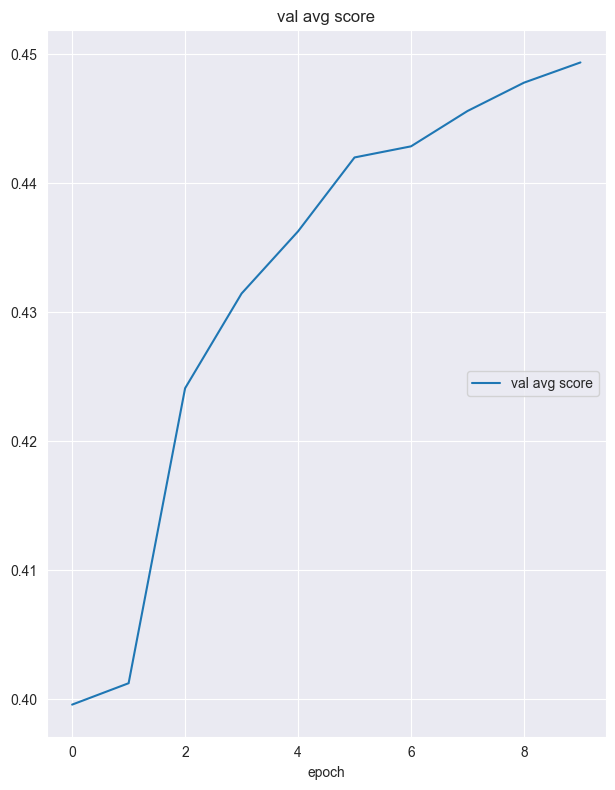

val avg score
	val avg score    	 (min:    0.400, max:    0.449, cur:    0.449)
Finished


In [379]:
finetune_dqn(env_train, dqn_agent_train, RESULTS_BASEPATH_TEST1, num_train_eps, num_mem_fill_eps, n_step, batch_size, update_frequency, val_data_path, model_name, mode='finetune')

print('Finished')

In [ ]:
subdir = 'data/cm/Crime_degree_val'

data_path = Path.cwd()/subdir

NUM_TEST_EPS = 10 # number of test episodes to run


actions3, reward_history3, ep_score_history3 = test_loop(env=env_train,
                                                        agent=dqn_agent_train,
                                                        NUM_TEST_EPS = NUM_TEST_EPS)


ep_score2 = { 'finetuned':ep_score_history3}

print(f'finetuned %.4f' %(np.mean(ep_score_history3)))
sns.boxplot(ep_score2)